# Stock Direction Prediction per Symbol


In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

client = bigquery.Client()

In [ ]:
PROJECT = "is3107-451916"
DS = "merged_data_6"
symbols = ["AAPL","HIMS","MGNI","NVDA","RDFN","SOFI"]

In [ ]:
merge_sql = f"""
CREATE OR REPLACE TABLE `{PROJECT}.{DS}.stock_data` AS
WITH combined_stocks AS (
  SELECT *, 'AAPL' AS symbol FROM `{PROJECT}.stock_dataset.AAPL`
  UNION ALL SELECT *, 'HIMS' AS symbol FROM `{PROJECT}.stock_dataset.HIMS`
  UNION ALL SELECT *, 'MGNI' AS symbol FROM `{PROJECT}.stock_dataset.MGNI`
  UNION ALL SELECT *, 'NVDA' AS symbol FROM `{PROJECT}.stock_dataset.NVDA`
  UNION ALL SELECT *, 'RDFN' AS symbol FROM `{PROJECT}.stock_dataset.RDFN`
  UNION ALL SELECT *, 'SOFI' AS symbol FROM `{PROJECT}.stock_dataset.SOFI`
)

SELECT
   s.* EXCEPT(
    `MACD Signal`,
    `MACD Histogram`,
    `Stochastic K`,
    `Stochastic D`
  ),

  -- now re‑add them with snake_case names
  `MACD Signal`    AS MACD_Signal,
  `MACD Histogram` AS MACD_Histogram,
  `Stochastic K`   AS Stochastic_K,
  `Stochastic D`   AS Stochastic_D,
  SAFE_CAST(f.sentiment_score AS FLOAT64)    AS sentiment_score,
  SAFE_CAST(f.news_count      AS INT64)      AS news_count,
  CAST(m.consumer_price_index  AS FLOAT64) AS consumer_price_index,
  CAST(m.unemployment_rate   AS FLOAT64)  AS unemployment_rate,
  CAST(m.federal_funds_rate    AS FLOAT64)  AS federal_funds_rate
FROM combined_stocks s
LEFT JOIN `{PROJECT}.sentiment.sentiment_data` f
  ON s.symbol = REPLACE(f.ticker, '.US', '') AND DATE(s.date) = DATE(f.date)
LEFT JOIN `{PROJECT}.macro_dataset.us_macro_indicators` m
  ON DATE(s.date) = DATE(m.date)
"""
client.query(merge_sql).result()
print("Done: stock_data merged")

Done: stock_data merged


# Price Direction Model

# Feature engineering per symbol

In [ ]:

for sym in symbols:
    print(f"\n▶ Processing {sym}")

    # Feature engineering for this symbol
    fe_sql = f"""
    CREATE OR REPLACE TABLE `{PROJECT}.{DS}.model_features_{sym}` AS
    SELECT *,
      CASE WHEN close >= prev_close THEN 1 ELSE -1 END AS price_direction
    FROM (
      SELECT
        date, symbol, close, volume,
        COALESCE(sentiment_score,
          LAST_VALUE(sentiment_score IGNORE NULLS)
            OVER (PARTITION BY symbol ORDER BY date), 0) AS sentiment_score,
        COALESCE(news_count, 0) AS news_count,
        AVG(close) OVER(PARTITION BY symbol ORDER BY date
          ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS moving_avg_7_day,
        AVG(close) OVER(PARTITION BY symbol ORDER BY date
          ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS moving_avg_30_day,
        LAG(close,1) OVER(PARTITION BY symbol ORDER BY date) AS prev_close,
        LAG(close,2) OVER(PARTITION BY symbol ORDER BY date) AS prev_close_2,
        LAG(close,3) OVER(PARTITION BY symbol ORDER BY date) AS prev_close_3,
        (close - LAG(close,1) OVER(PARTITION BY symbol ORDER BY date))
          AS price_diff_1_day,
        CASE
          WHEN LAG(close,1) OVER(PARTITION BY symbol ORDER BY date)
             > LAG(close,2) OVER(PARTITION BY symbol ORDER BY date)
           AND LAG(close,2) OVER(PARTITION BY symbol ORDER BY date)
             > LAG(close,3) OVER(PARTITION BY symbol ORDER BY date)
          THEN 1 ELSE -1
        END AS trend_3_day,
        RSI, MACD, MACD_Signal, MACD_Histogram,
        Stochastic_K, Stochastic_D, ATR,
        Lower_Band, Middle_Band, Upper_Band, SMA, EMA,
        (close - Middle_Band)/(Upper_Band-Lower_Band) AS band_position,
        CASE WHEN close>Upper_Band THEN 1 WHEN close<Lower_Band THEN -1 ELSE 0 END AS band_signal,
        SIGN(`MACD_Histogram`) AS macd_signal_direction,
        CASE WHEN MACD>0 AND `MACD_Signal`>0 THEN 1
             WHEN MACD<0 AND `MACD_Signal`<0 THEN -1 ELSE 0 END AS macd_trend,
        CASE WHEN RSI>70 THEN 1 WHEN RSI<30 THEN -1 ELSE 0 END AS rsi_signal,
        CASE WHEN `Stochastic_K`>80 AND `Stochastic_D`>80 THEN 1
             WHEN `Stochastic_K`<20 AND `Stochastic_D`<20 THEN -1 ELSE 0 END AS stoch_signal,
        CASE WHEN EMA>SMA AND LAG(EMA,1) OVER(PARTITION BY symbol ORDER BY date)
                    <= LAG(SMA,1) OVER(PARTITION BY symbol ORDER BY date) THEN 1
             WHEN EMA<SMA AND LAG(EMA,1) OVER(PARTITION BY symbol ORDER BY date)
                    >= LAG(SMA,1) OVER(PARTITION BY symbol ORDER BY date) THEN -1
             ELSE 0 END AS ma_crossover,
        ATR/close AS relative_volatility
      FROM `{PROJECT}.{DS}.stock_data`
      WHERE symbol = '{sym}'
    )
    """
    client.query(fe_sql).result()
    print(f"  • Features created for {sym}")



▶ Processing AAPL
  • Features created for AAPL

▶ Processing HIMS
  • Features created for HIMS

▶ Processing MGNI
  • Features created for MGNI

▶ Processing NVDA
  • Features created for NVDA

▶ Processing RDFN
  • Features created for RDFN

▶ Processing SOFI
  • Features created for SOFI


## Train logistic regression model

In [ ]:
for sym in symbols:
    print(f"\n▶ Processing {sym}")

    train_sql = f"""
    CREATE OR REPLACE MODEL `{PROJECT}.{DS}.stock_direction_model_{sym}`
    OPTIONS(
      MODEL_TYPE='LOGISTIC_REG',
      INPUT_LABEL_COLS=['price_direction'],
      AUTO_CLASS_WEIGHTS=TRUE,
      DATA_SPLIT_METHOD='CUSTOM',
      DATA_SPLIT_COL='is_training_data'
    ) AS
    WITH FeatureDataWithSplit AS (
      SELECT *,
        CASE
          WHEN date <= '2025-01-30' THEN TRUE
          WHEN date > '2025-01-30' AND date <= '2025-02-28' THEN FALSE
          ELSE NULL
        END AS is_training_data
      FROM `{PROJECT}.{DS}.model_features_{sym}`
      WHERE price_direction IS NOT NULL
    )
    SELECT
      date, symbol, close, volume, sentiment_score, news_count,
      moving_avg_7_day, moving_avg_30_day,
      prev_close, prev_close_2, prev_close_3,
      price_diff_1_day, trend_3_day,
      RSI, MACD, MACD_Signal, MACD_Histogram,
        Stochastic_K, Stochastic_D,
      ATR, Lower_Band, Middle_Band, Upper_Band, SMA, EMA,
      band_position, band_signal, macd_signal_direction,
      macd_trend, rsi_signal, stoch_signal, ma_crossover,
      relative_volatility, price_direction, is_training_data
    FROM FeatureDataWithSplit
    WHERE is_training_data IS NOT NULL
    """
    client.query(train_sql).result()
    print(f"  • Model trained for {sym}")



▶ Processing AAPL
  • Model trained for AAPL

▶ Processing HIMS
  • Model trained for HIMS

▶ Processing MGNI
  • Model trained for MGNI

▶ Processing NVDA
  • Model trained for NVDA

▶ Processing RDFN
  • Model trained for RDFN

▶ Processing SOFI
  • Model trained for SOFI


# Recalibrating



▶ Threshold sweep for AAPL
  • Best threshold = 0.4275
    Recall (TPR) = 0.946, FPR = 0.222



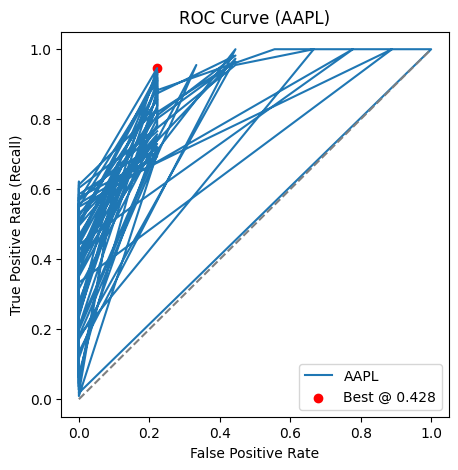


▶ Threshold sweep for HIMS
  • Best threshold = 0.5504
    Recall (TPR) = 0.906, FPR = 0.000



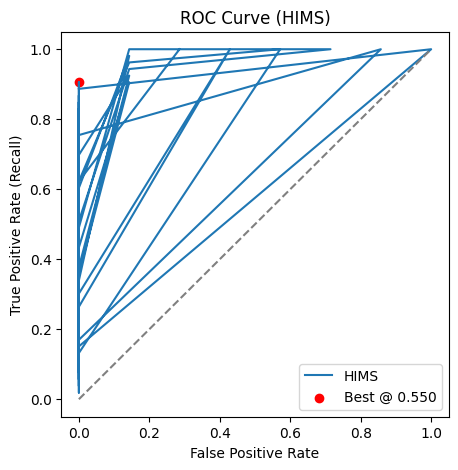


▶ Threshold sweep for MGNI
  • Best threshold = 0.4963
    Recall (TPR) = 0.957, FPR = 0.000



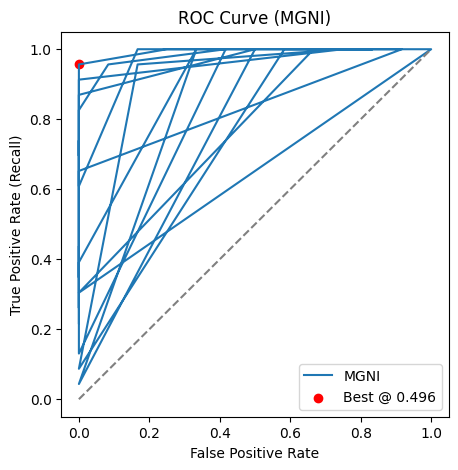


▶ Threshold sweep for NVDA
  • Best threshold = 0.4376
    Recall (TPR) = 1.000, FPR = 0.333



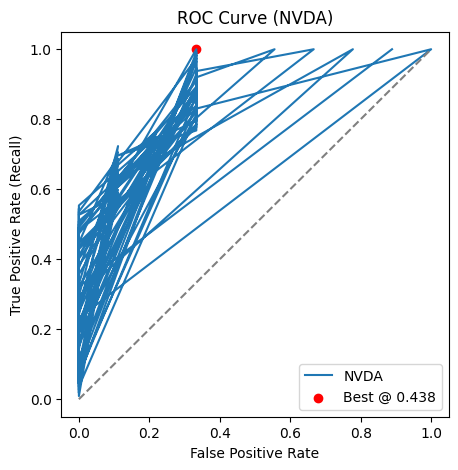


▶ Threshold sweep for RDFN
  • Best threshold = 0.4900
    Recall (TPR) = 0.940, FPR = 0.083



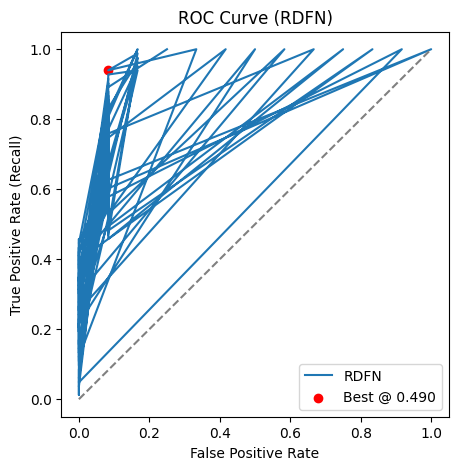


▶ Threshold sweep for SOFI
  • Best threshold = 0.4841
    Recall (TPR) = 0.912, FPR = 0.083



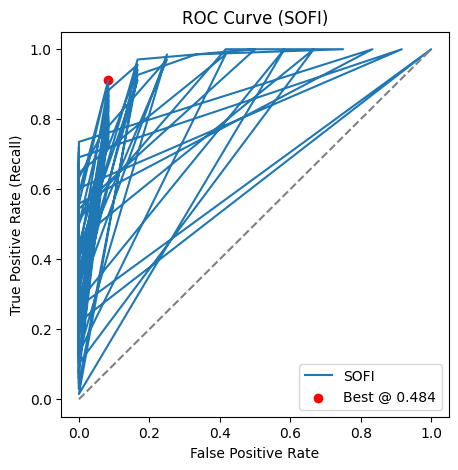

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

thresholds = {}

for sym in symbols:
    print(f"\n▶ Threshold sweep for {sym}")

    roc_df = client.query(f"""
      SELECT
        threshold,
        recall,
        false_positives,
        true_negatives
      FROM ML.ROC_CURVE(
        MODEL `{PROJECT}.{DS}.stock_direction_model_{sym}`,
        (
          SELECT *
          FROM `{PROJECT}.{DS}.model_features_{sym}`
          WHERE date > '2025-01-30' AND date <= '2025-02-28'
        )
      )
    """).to_dataframe()

    # 2) compute FPR and Youden's J
    roc_df['fpr'] = roc_df['false_positives'] / (roc_df['false_positives'] + roc_df['true_negatives'])
    roc_df['youden_j'] = roc_df['recall'] - roc_df['fpr']

    best = roc_df.loc[roc_df['youden_j'].idxmax()]

    thresholds[sym] = best.threshold
    print(f"  • Best threshold = {best.threshold:.4f}")
    print(f"    Recall (TPR) = {best.recall:.3f}, FPR = {best.fpr:.3f}\n")

    # 3) Plot ROC curve
    plt.figure(figsize=(5,5))
    plt.plot(roc_df['fpr'], roc_df['recall'], label=sym)
    plt.scatter(best['fpr'], best['recall'], color='red',
                label=f"Best @ {best.threshold:.3f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve ({sym})")
    plt.legend()
    plt.show()


   bin  avg_pred  frac_pos
0    0  0.399326  0.500000
1    1  0.430336  0.916667
2    2  0.452510  1.000000
3    3  0.480481  0.916667
4    4  0.492094  0.916667
5    5  0.507301  1.000000
6    6  0.529748  1.000000
7    7  0.545523  1.000000
8    8  0.566441  1.000000
9    9  0.596748  1.000000


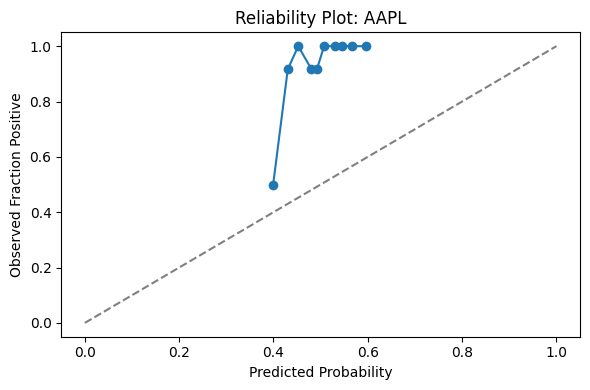

In [ ]:
# ── Fixed Calibration Check for AAPL ──

# 1) Fetch raw predicted probabilities for the “up” class (label = 1)
pred_df = client.query(f"""
  SELECT
    price_direction   AS actual,
    (
      SELECT p.prob
      FROM UNNEST(predicted_price_direction_probs) AS p
      WHERE p.label = 1
    ) AS prob_up
  FROM ML.PREDICT(
    MODEL `{PROJECT}.{DS}.stock_direction_model_AAPL`,
    (
      SELECT *
      FROM `{PROJECT}.{DS}.model_features_AAPL`
      WHERE date > '2025-01-30' AND date <= '2025-02-28'
    )
  )
""").to_dataframe()

# 2) Bin into deciles and compute observed frequency
pred_df['bin'] = pd.qcut(pred_df['prob_up'], 10, labels=False)
rel = pred_df.groupby('bin').agg(
    avg_pred=('prob_up','mean'),
    frac_pos=('actual', lambda s: (s==1).mean())
).reset_index()

print(rel)

# 3) Plot reliability curve
plt.figure(figsize=(6,4))
plt.plot(rel['avg_pred'], rel['frac_pos'], 'o-')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Fraction Positive")
plt.title("Reliability Plot: AAPL")
plt.tight_layout()
plt.show()


,precision,recall,accuracy,f1_score,log_loss,roc_auc,train_end,test_start,test_end
0,0.964286,1.000000,0.966667,0.981818,0.630201,0.975975,2025-01-31,2025-02-01,2025-02-07
1,1.000000,1.000000,1.000000,1.000000,0.573547,0.000000,2025-02-07,2025-02-08,2025-02-14
2,0.944444,0.772727,0.750000,0.850000,0.716630,0.887114,2025-02-14,2025-02-15,2025-02-21
3,1.000000,0.259259,0.333333,0.411765,0.764014,1.000000,2025-02-21,2025-02-22,2025-02-28


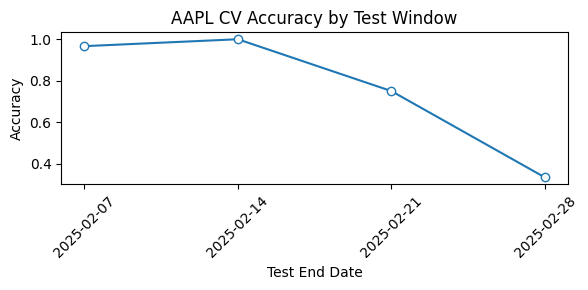

In [ ]:
# ── Rolling Time‑Series CV for AAPL ──

import datetime
from dateutil.relativedelta import relativedelta

# Define rolling splits (train_end, test_start, test_end)
splits = [
    ("2025-01-31","2025-02-01","2025-02-07"),
    ("2025-02-07","2025-02-08","2025-02-14"),
    ("2025-02-14","2025-02-15","2025-02-21"),
    ("2025-02-21","2025-02-22","2025-02-28"),
]

cv_results = []

for train_end, test_start, test_end in splits:
    # train on all data ≤ train_end, evaluate on test window
    eval_sql = f"""
      SELECT *
      FROM ML.EVALUATE(
        MODEL `{PROJECT}.{DS}.stock_direction_model_AAPL`,
        (
          SELECT *
          FROM `{PROJECT}.{DS}.model_features_AAPL`
          WHERE date > '{train_end}' AND date <= '{test_end}'
        ),
        STRUCT(0.4750 AS threshold)
      )
    """
    df = client.query(eval_sql).to_dataframe()
    df['train_end'] = train_end
    df['test_start'] = test_start
    df['test_end']   = test_end
    cv_results.append(df)

cv_df = pd.concat(cv_results, ignore_index=True)
display(cv_df)

# Plot CV accuracy over the four folds
plt.figure(figsize=(6,3))
plt.plot(cv_df['test_end'], cv_df['accuracy'], 'o-', markerfacecolor='white')
plt.xticks(rotation=45)
plt.title("AAPL CV Accuracy by Test Window")
plt.xlabel("Test End Date")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


# Evaluate mode

In [ ]:
metrics_list = []

for sym in symbols:
    print(f"\n▶ Evaluating for {sym}")
    th = thresholds.get(sym)

    eval_query = f"""
    WITH eval_input AS (
      SELECT *
      FROM `{PROJECT}.{DS}.model_features_{sym}`
      WHERE date > '2025-01-30' AND date <= '2025-02-28'
    )

    SELECT *
    FROM ML.EVALUATE(
      MODEL `{PROJECT}.{DS}.stock_direction_model_{sym}`,
      (SELECT * FROM eval_input),
      STRUCT({th} AS threshold)
    )
    """
    metrics = client.query(eval_query).to_dataframe()
    print("  • Evaluation metrics:")
    display(metrics)

    df = metrics
    df['symbol'] = sym
    metrics_list.append(df)

    cm_query = f"""
    WITH eval_input AS (
      SELECT *
      FROM `{PROJECT}.{DS}.model_features_{sym}`
      WHERE date > '2025-01-30' AND date <= '2025-02-28'
    )

    SELECT *
    FROM ML.CONFUSION_MATRIX(
      MODEL `{PROJECT}.{DS}.stock_direction_model_{sym}`,
      (SELECT * FROM eval_input),
      STRUCT({th} AS threshold)
    )
    """
    cm = client.query(cm_query).to_dataframe()
    print("  • Confusion matrix:")
    display(cm)



▶ Evaluating for AAPL
  • Evaluation metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.981308,0.945946,0.933333,0.963303,0.67272,0.913352


  • Confusion matrix:


,expected_label,_-1,_1
0,-1,7,2
1,1,6,105



▶ Evaluating for HIMS
  • Evaluation metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1.0,0.90566,0.916667,0.950495,0.33483,0.987429


  • Confusion matrix:


,expected_label,_-1,_1
0,-1,7,0
1,1,5,48



▶ Evaluating for MGNI
  • Evaluation metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1.0,0.956522,0.971429,0.977778,0.619195,0.993659


  • Confusion matrix:


,expected_label,_-1,_1
0,-1,12,0
1,1,1,22



▶ Evaluating for NVDA
  • Evaluation metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.973913,1.0,0.975207,0.986784,0.668164,0.894433


  • Confusion matrix:


,expected_label,_-1,_1
0,-1,6,3
1,1,0,112



▶ Evaluating for RDFN
  • Evaluation metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.987342,0.939759,0.936842,0.962963,0.651077,0.950376


  • Confusion matrix:


,expected_label,_-1,_1
0,-1,11,1
1,1,5,78



▶ Evaluating for SOFI
  • Evaluation metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.984127,0.911765,0.9125,0.946565,0.636514,0.966393


  • Confusion matrix:


,expected_label,_-1,_1
0,-1,11,1
1,1,6,62


,precision,recall,accuracy,f1_score,log_loss,roc_auc,symbol
0,0.981308,0.945946,0.933333,0.963303,0.672720,0.913352,AAPL
1,1.000000,0.905660,0.916667,0.950495,0.334830,0.987429,HIMS
2,1.000000,0.956522,0.971429,0.977778,0.619195,0.993659,MGNI
3,0.973913,1.000000,0.975207,0.986784,0.668164,0.894433,NVDA
4,0.987342,0.939759,0.936842,0.962963,0.651077,0.950376,RDFN
5,0.984127,0.911765,0.912500,0.946565,0.636514,0.966393,SOFI


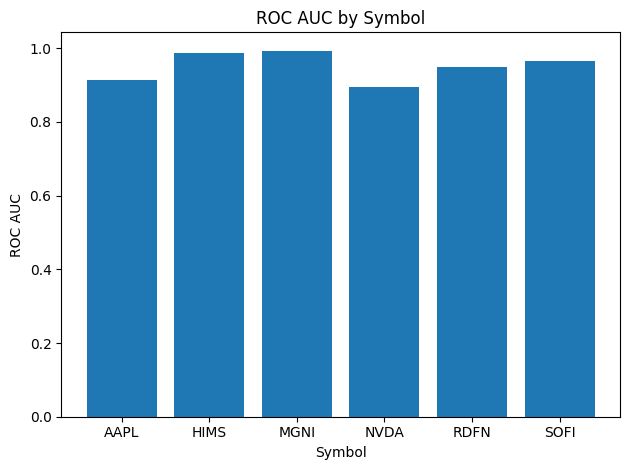

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

all_metrics = pd.concat(metrics_list, ignore_index=True)

display(all_metrics)

plt.figure()
plt.bar(all_metrics['symbol'], all_metrics['roc_auc'])
plt.title('ROC AUC by Symbol')
plt.xlabel('Symbol')
plt.ylabel('ROC AUC')
plt.tight_layout()
plt.show()